In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
customers = pd.read_csv("Ecommerce/olist_customers_dataset.csv")
order_items = pd.read_csv("Ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("Ecommerce/olist_orders_dataset.csv")
products = pd.read_csv("Ecommerce/olist_products_dataset.csv")
reviews = pd.read_csv("Ecommerce/olist_order_reviews_dataset.csv")
category_map = pd.read_csv("Ecommerce/product_category_name_translation.csv")


products = products.merge(category_map, on="product_category_name", how="left")
products = products.drop(columns=['product_category_name'])
products = products.rename(columns={'product_category_name_english': 'product_category'})

display(order_items.head())
display(products.head())
display(orders.head())

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

product_id  product_name_lenght  \
0  1e9e8ef04dbcff4541ed26657ea517e5                 40.0   
1  3aa071139cb16b67ca9e5dea641aaa2f                 44.0   
2  96bd76ec8810374ed1b65e291975717f                 46.0   
3  cef67bcfe19066a932b7673e239eb23d                 27.0   
4  9dc1a7de274444849c219cff195d0b71                 37.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       287.0                 1.0             225.0   
1                       276.0                 1.0            1000.0   
2                       250.0                 1.0             154.0   
3                       261.0                 1.0             371.0   
4                       402.0                 4.0             625.0   

   product_length_cm  product_height_cm  product_width_cm product_category  
0               16.0               10.0              14.0        perfumery  
1               30.0               18.0              20.0              art  
2               18.0                9.0              15.0   sports_leisure  
3               26.0                4.0              26.0             baby  
4               20.0               17.0              13.0       housewares

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [3]:
# product_id Í∏∞Ï§ÄÏúºÎ°ú orders_itemÏù¥Îûë products Î≥ëÌï©
# order_id Í∏∞Ï§ÄÏúºÎ°ú ordersÎûë Î≥ëÌï©

# 1Ô∏è‚É£ productsÏôÄ order_items Î≥ëÌï© (product_id Í∏∞Ï§Ä)
items_with_category = order_items.merge(products[['product_id','product_category']], on='product_id', how='left')

# 2Ô∏è‚É£ ordersÏôÄ Î≥ëÌï© (order_id Í∏∞Ï§Ä)
full_order_data = items_with_category.merge(
    orders[['order_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']],
    on='order_id',
    how='left'
)

# 3Ô∏è‚É£ Ï£ºÎ¨∏ÏùºÏûê datetime Î≥ÄÌôò
full_order_data['order_purchase_timestamp'] = pd.to_datetime(full_order_data['order_purchase_timestamp'])
full_order_data['order_delivered_customer_date'] = pd.to_datetime(full_order_data['order_delivered_customer_date'])
full_order_data['order_estimated_delivery_date'] = pd.to_datetime(full_order_data['order_estimated_delivery_date'])

# Î∞∞ÏÜ° ÏÑ±Í≥µÌïú Ïï†Îì§Îßå Î≥º Í±∞ÏûÑ!
success_full_orders = full_order_data[full_order_data['order_delivered_customer_date'].notna()].copy()

# ÌôïÏù∏
success_full_orders.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value product_category  \
0  2017-09-19 09:45:35   58.90          13.29       cool_stuff   
1  2017-05-03 11:05:13  239.90          19.93         pet_shop   
2  2018-01-18 14:48:30  199.00          17.87  furniture_decor   
3  2018-08-15 10:10:18   12.99          12.79        perfumery   
4  2017-02-13 13:57:51  199.90          18.14     garden_tools   

  order_purchase_timestamp order_delivered_customer_date  \
0      2017-09-13 08:59:02           2017-09-20 23:43:48   
1      2017-04-26 10:53:06           2017-05-12 16:04:24   
2      2018-01-14 14:33:31           2018-01-22 13:19:16   
3      2018-08-08 10:00:35           2018-08-14 13:32:39   
4      2017-02-04 13:57:51           2017-03-01 16:42:31   

  order_estimated_delivery_date  
0                    2017-09-29  
1                    2017-05-15  
2                    2018-02-05  
3                    2018-08-20  
4                    2017-03-17

In [4]:
# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ìï≠Î™© ÌôïÏù∏
category_summary = success_full_orders.groupby('product_category')['order_id'].count().reset_index()
category_summary.rename(columns={'order_id':'Ï£ºÎ¨∏Í±¥Ïàò'}, inplace=True)
category_summary = category_summary.sort_values(by='Ï£ºÎ¨∏Í±¥Ïàò', ascending=False)

category_summary.head(10)  # ÏÉÅÏúÑ 10Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ ÌôïÏù∏

product_category   Ï£ºÎ¨∏Í±¥Ïàò
7          bed_bath_table  10953
43          health_beauty   9467
65         sports_leisure   8431
39        furniture_decor   8160
15  computers_accessories   7643
49             housewares   6795
70          watches_gifts   5857
68              telephony   4430
42           garden_tools   4268
5                    auto   4139

order_month  product_category  ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò
0     2016-09     health_beauty       3
1     2016-10  air_conditioning       8
2     2016-10             audio       2
3     2016-10              auto       8
4     2016-10              baby      11

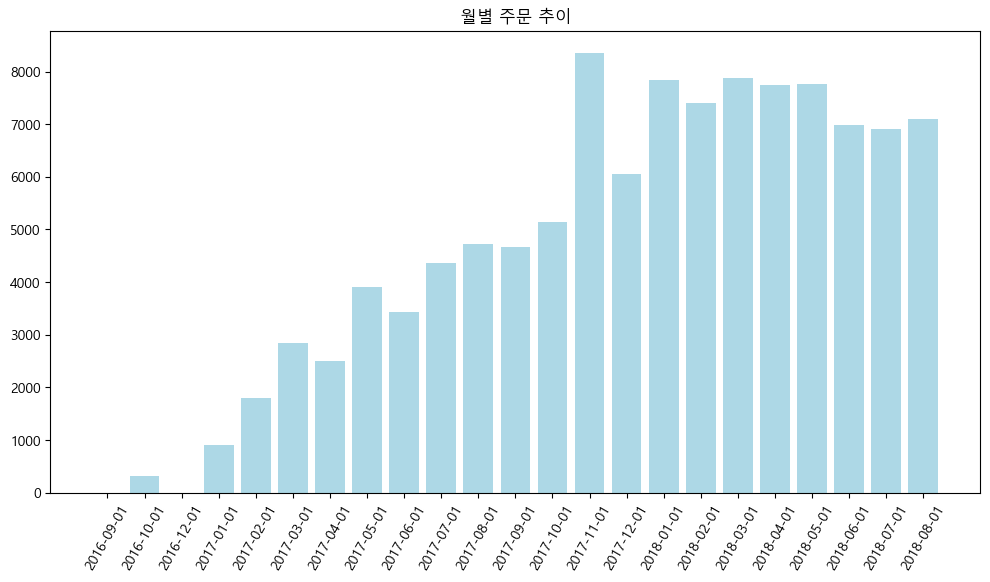

order_month          product_category  ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò
0  2016-09-01             health_beauty       3
1  2016-10-01           furniture_decor      65
2  2016-10-01             health_beauty      41
3  2016-10-01                 perfumery      31
4  2016-12-01  fashion_bags_accessories       1

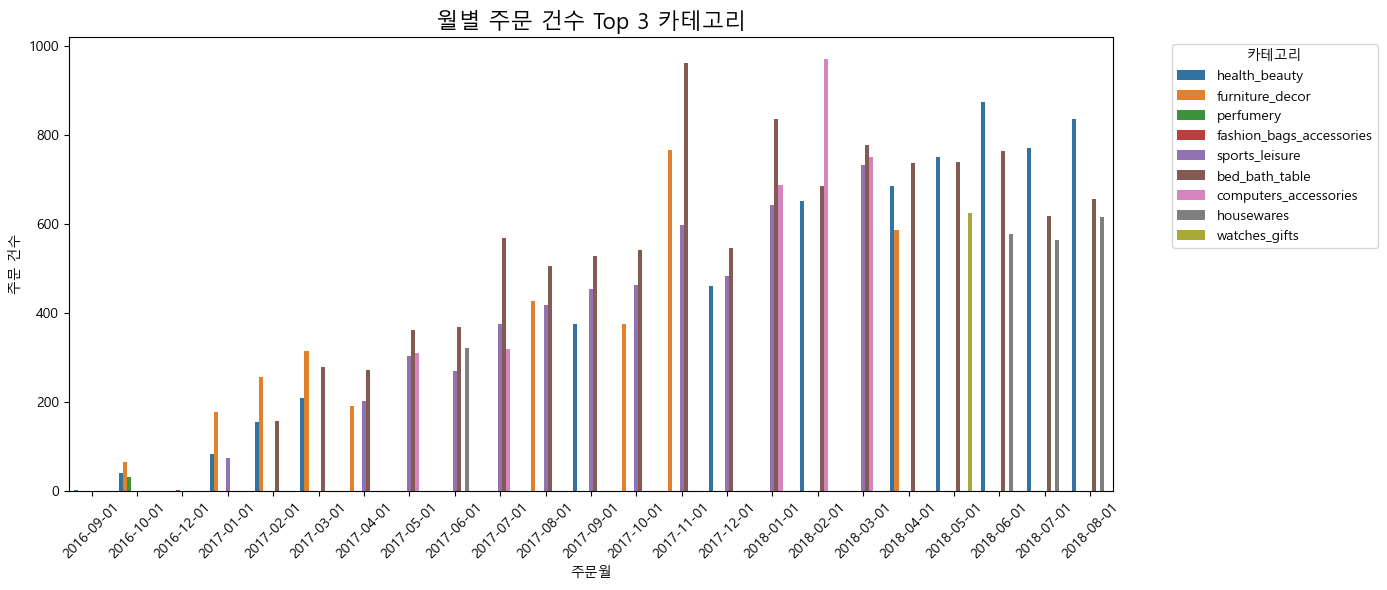

In [5]:
# Ï£ºÎ¨∏Ïõî Ïª¨Îüº Ï∂îÍ∞Ä
success_full_orders['order_month'] = success_full_orders['order_purchase_timestamp'].dt.to_period('M')

# ÏõîÎ≥Ñ, Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ï£ºÎ¨∏ Í±¥Ïàò
monthly_category_trend = success_full_orders.groupby(['order_month','product_category'])['order_id'].count().reset_index()
monthly_category_trend.rename(columns={'order_id':'ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'}, inplace=True)
monthly_category_trend.groupby('order_month')
display(monthly_category_trend.head())

# order_monthÎ•º datetimeÏúºÎ°ú Î≥ÄÌôò!!!!!!!!!!!!!!!
monthly_category_trend['order_month'] = monthly_category_trend['order_month'].dt.to_timestamp()


# ÏõîÎ≥Ñ Ï£ºÎ¨∏ Ï∂îÏù¥ ÎßâÎåÄÍ∑∏ÎûòÌîÑ
monthly_total = monthly_category_trend.groupby('order_month')['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.bar(monthly_total['order_month'].astype(str), monthly_total['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'], color='lightblue')
plt.xticks(rotation=60)
plt.title('ÏõîÎ≥Ñ Ï£ºÎ¨∏ Ï∂îÏù¥')
plt.show()




# ÏõîÎ≥Ñ Ï£ºÎ¨∏Í±¥Ïàò topNÍ∞ú ÎΩëÍ∏∞
N = 3
monthly_topN = (monthly_category_trend
    .sort_values(['order_month', 'ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'], ascending=[True, False])
    .groupby('order_month')
    .head(N)
    .reset_index(drop=True)
)
display(monthly_topN.head())


# ÏõîÎ≥Ñ top3 ÏãúÍ∞ÅÌôî
plt.figure(figsize=(14,6))
sns.barplot(
    data=monthly_topN,
    x='order_month',
    y='ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò',
    hue='product_category'
)

plt.title('ÏõîÎ≥Ñ Ï£ºÎ¨∏ Í±¥Ïàò Top 3 Ïπ¥ÌÖåÍ≥†Î¶¨', fontsize=16)
plt.xlabel('Ï£ºÎ¨∏Ïõî')
plt.ylabel('Ï£ºÎ¨∏ Í±¥Ïàò')
plt.legend(title='Ïπ¥ÌÖåÍ≥†Î¶¨', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥ ÌååÏïÖ

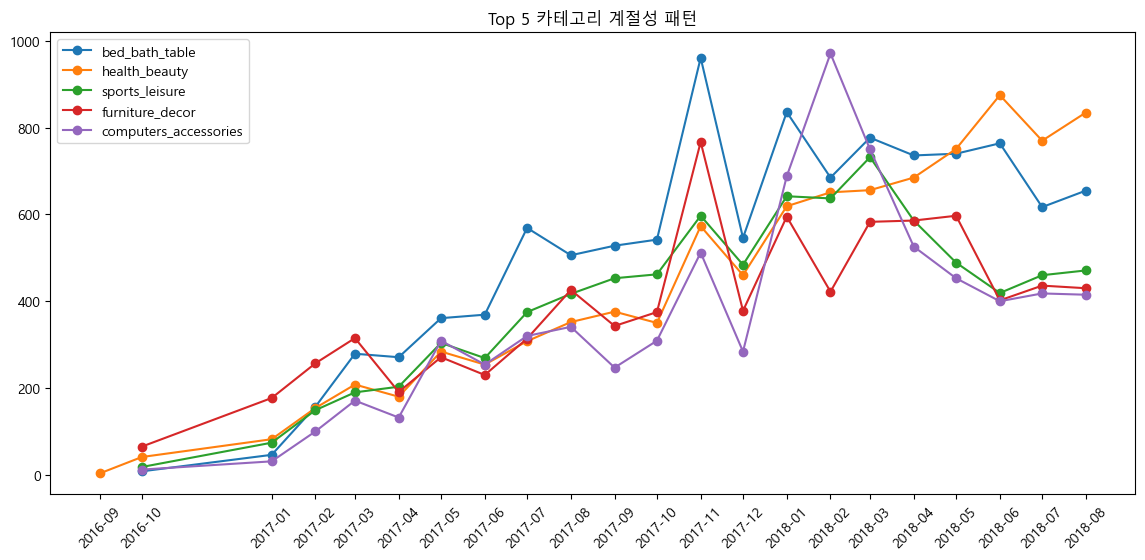

In [6]:
top_categories = monthly_category_trend.groupby('product_category')['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'].sum().nlargest(5).index
seasonal_trend = monthly_category_trend[monthly_category_trend['product_category'].isin(top_categories)]
# display(seasonal_trend)

# display(seasonal_trend[seasonal_trend['order_month'].dt.month == 11])
# display(seasonal_trend[seasonal_trend['product_category'] == 'health_beauty'])
# display(seasonal_trend[seasonal_trend['product_category'] == 'bed_bath_table'])

plt.figure(figsize=(14,6))
for cat in top_categories:
    subset = seasonal_trend[seasonal_trend['product_category'] == cat]
    plt.plot(subset['order_month'], subset['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'], marker='o', label=cat)

plt.xticks(
    ticks=seasonal_trend['order_month'].unique(),
    labels=[x.strftime('%Y-%m') for x in seasonal_trend['order_month'].unique()],
    rotation=45
)
plt.title('Top 5 Ïπ¥ÌÖåÍ≥†Î¶¨ Í≥ÑÏ†àÏÑ± Ìå®ÌÑ¥')
plt.legend()
plt.show()

In [7]:
# Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏
# 1. 11Ïõî Î™®Îì† Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú Îß§Ï∂ú Í∏âÏ¶ù.
# 2. 11ÏõîÏóê 'bed_bath_table', 'furniture_decor' Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä Í∏âÏ¶ù -> Î∏åÎùºÏßàÏùò Ï£ºÏöî ÏáºÌïë ÏãúÏ¶å
# 3. 2ÏõîÏóê 'computers_accessories Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä Í∏âÏ¶ù Ïù¥Ïú† -> ÌïôÏÇ¨ ÏùºÏ†ïÍ≥º Í¥ÄÎ†®

# 11Ïõî 'bed_bath_table' Í∏âÏ¶ù: Î∏îÎûô ÌîÑÎùºÏù¥Îç∞Ïù¥ (Black Friday)
# 11ÏõîÏóê Ïπ®Íµ¨, ÏöïÏã§Ïö©Ìíà, ÌÖåÏù¥Î∏îÏõ®Ïñ¥ÏôÄ Í∞ôÏùÄ Í∞ÄÏ†ïÏö©Ìíà ÌåêÎß§Í∞Ä Í∏âÏ¶ùÌïú Í≤ÉÏùÄ Î∏îÎûô ÌîÑÎùºÏù¥Îç∞Ïù¥ ÎïåÎ¨∏Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ Îß§Ïö∞ ÎÜíÏäµÎãàÎã§.
# ÎåÄÍ∑úÎ™® Ìï†Ïù∏ ÌñâÏÇ¨: Î∏åÎùº„Ç∏„É´ÏóêÏÑú Î∏îÎûô ÌîÑÎùºÏù¥Îç∞Ïù¥Îäî Ïó∞Ï§ë Í∞ÄÏû• ÌÅ∞ ÏáºÌïë Ïù¥Î≤§Ìä∏ Ï§ë ÌïòÎÇòÏûÖÎãàÎã§. Îã® ÌïòÎ£®Í∞Ä ÏïÑÎãå 'Î∏îÎûô ÏúÑÌÅ¨(Black Week)' ÎòêÎäî 'Î∏îÎûô ÎÖ∏Î≤∞Î≤Ñ(Black November)'Î°ú 
# Î∂àÎ¶¨Î©∞ Ìïú Îã¨ ÎÇ¥ÎÇ¥ ÎåÄÍ∑úÎ™® Ìï†Ïù∏ ÌñâÏÇ¨Í∞Ä ÏßÑÌñâÎê©ÎãàÎã§.
# Í∞ÄÏ†ïÏö©Ìíà Ïù∏Í∏∞: Ïù¥ Í∏∞Í∞Ñ ÎèôÏïà ÏÜåÎπÑÏûêÎì§ÏùÄ ÌèâÏÜåÏóê Í∞ÄÍ≤©Ïù¥ Î∂ÄÎã¥Ïä§Îü¨Ïõ†Îçò Í∞ÄÍµ¨, Ï†ÑÏûêÏ†úÌíà, Í∑∏Î¶¨Í≥† Ïπ®Íµ¨ Î∞è ÏÉùÌôúÏö©Ìíà(bed_bath_table)ÏùÑ Ï†ÄÎ†¥ÌïòÍ≤å Íµ¨Îß§ÌïòÎ†§Îäî Í≤ΩÌñ•Ïù¥ Í∞ïÌï©ÎãàÎã§. 
# Ïó∞ÎßêÏùÑ ÎßûÏù¥ÌïòÏó¨ ÏßëÏïàÏùÑ ÏÉàÎ°≠Í≤å Îã®Ïû•ÌïòÎ†§Îäî ÏàòÏöîÏôÄ ÎßûÎ¨ºÎ†§ Ìï¥Îãπ Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Îß§Ï∂úÏù¥ Ìè≠Î∞úÏ†ÅÏúºÎ°ú Ï¶ùÍ∞ÄÌïòÍ≤å Îê©ÎãàÎã§.

# 2Ïõî 'computers_accessories' Í∏âÏ¶ù: Ïã†ÌïôÍ∏∞ Ï§ÄÎπÑ (Volta √†s Aulas)
# 2ÏõîÏóê Ïª¥Ìì®ÌÑ∞ Ïï°ÏÑ∏ÏÑúÎ¶¨ ÌåêÎß§Í∞Ä Í∏âÏ¶ùÌïú Ïù¥Ïú†Îäî Î∏åÎùºÏßàÏùò Ïã†ÌïôÍ∏∞ ÏãúÏûëÍ≥º Í¥ÄÎ†®Ïù¥ ÏûàÏäµÎãàÎã§.
# 'Volta √†s Aulas' (Back to School): Î∏åÎùºÏßàÏùò ÌïôÎÖÑÏùÄ Î≥¥ÌÜµ 2ÏõîÏóê ÏãúÏûëÎê©ÎãàÎã§. Îî∞ÎùºÏÑú 1Ïõî ÎßêÎ∂ÄÌÑ∞ 2ÏõîÍπåÏßÄÎäî ÌïôÏÉùÎì§Ïù¥ ÌïôÍµêÎ°ú ÎèåÏïÑÍ∞ÄÎäî Í≤ÉÏùÑ Ï§ÄÎπÑ

# ÌïôÏäµ Ï§ÄÎπÑÎ¨º ÏàòÏöî: Ïù¥ Í∏∞Í∞Ñ ÎèôÏïà ÌïôÏÉùÍ≥º ÌïôÎ∂ÄÎ™®Îì§ÏùÄ ÏÉà ÌïôÎÖÑÏóê ÌïÑÏöîÌïú ÌïôÏäµ Ï§ÄÎπÑÎ¨ºÏùÑ Íµ¨Îß§Ìï©ÎãàÎã§. ÏµúÍ∑º ÍµêÏú° ÌôòÍ≤ΩÏù¥ ÎîîÏßÄÌÑ∏ÌôîÎêòÎ©¥ÏÑú ÎÖ∏Ìä∏Î∂Å, ÌÉúÎ∏îÎ¶øÍ≥º Í∞ôÏùÄ Í∏∞Í∏∞ÎøêÎßå ÏïÑÎãàÎùº 
# ÌÇ§Î≥¥Îìú, ÎßàÏö∞Ïä§, ÏõπÏ∫†, Ìó§ÎìúÏÖã Îì± Ïª¥Ìì®ÌÑ∞ Í¥ÄÎ†® Ïï°ÏÑ∏ÏÑúÎ¶¨ ÏàòÏöîÍ∞Ä ÌÅ¨Í≤å Ï¶ùÍ∞ÄÌï©ÎãàÎã§. ÎßéÏùÄ Ïú†ÌÜµÏóÖÏ≤¥Îì§Ïù¥ Ïù¥ ÏãúÍ∏∞Ïóê ÎßûÏ∂∞ Ï†ÑÏûêÏ†úÌíà Î∞è Ïª¥Ìì®ÌÑ∞ Ïï°ÏÑ∏ÏÑúÎ¶¨ Ìï†Ïù∏ ÌîÑÎ°úÎ™®ÏÖòÏùÑ 
# ÏßÑÌñâÌïòÎäî Í≤ÉÎèÑ Îß§Ï∂ú Í∏âÏ¶ùÏùò Ìïú ÏöîÏù∏ÏûÖÎãàÎã§.

# health_beautyÏùÄ Íæ∏Ï§ÄÌûà Ï¶ùÍ∞ÄÌïòÎäîÎç∞
# 6Ïõî ÌåêÎß§ Í∏âÏ¶ùÏùò ÌïµÏã¨ ÏõêÏù∏
# 1. Ïó∞Ïù∏Îì§Ïùò ÎÇ† (Dia dos Namorados)
# Í∞ÄÏû• ÌÅ∞ Ïù¥Ïú†Îäî Î∏åÎùºÏßàÏùò 'Î∞∏Îü∞ÌÉÄÏù∏Îç∞Ïù¥'Ïù∏ 'Ïó∞Ïù∏Îì§Ïùò ÎÇ†'(6Ïõî 12Ïùº) ÎïåÎ¨∏ÏûÖÎãàÎã§. Î∏åÎùºÏßàÏùÄ 6Ïõî 12ÏùºÏóê Ïó∞Ïù∏Îì§Ïù¥ ÏÑ†Î¨ºÏùÑ Ï£ºÍ≥†Î∞õÏúºÎ©∞ ÏÇ¨ÎûëÏùÑ ÌëúÌòÑÌï©ÎãàÎã§.
# Ï£ºÏöî ÏÑ†Î¨º ÌíàÎ™©: Ìñ•Ïàò, ÌôîÏû•Ìíà ÏÑ∏Ìä∏, Ïä§ÌÇ®ÏºÄÏñ¥ Ï†úÌíà, ÎÇ®ÏÑ±Ïö© Í∑∏Î£®Î∞ç Ï†úÌíà Îì± Ìó¨Ïä§Î∑∞Ìã∞ Ïπ¥ÌÖåÍ≥†Î¶¨Îäî 'Ïó∞Ïù∏Îì§Ïùò ÎÇ†'Ïóê Í∞ÄÏû• Ïù∏Í∏∞ ÏûàÎäî ÏÑ†Î¨º Ï§ë ÌïòÎÇòÏûÖÎãàÎã§.
# ÏàòÏöî ÏßëÏ§ë: 6Ïõî Ï¥àÎ∂ÄÌÑ∞ Í∏∞ÎÖêÏùºÏùÑ Ï§ÄÎπÑÌïòÍ∏∞ ÏúÑÌïú ÏÑ†Î¨º Íµ¨Îß§ ÏàòÏöîÍ∞Ä Î™∞Î¶¨Î©¥ÏÑú Ìó¨Ïä§Î∑∞Ìã∞ Ïπ¥ÌÖåÍ≥†Î¶¨Ïùò Îß§Ï∂úÏù¥ Îã®Í∏∞Ï†ÅÏúºÎ°ú Í∏âÏ¶ùÌïòÍ≤å Îê©ÎãàÎã§.

# 7Ïõî ÌåêÎß§Îüâ ÏÜåÌè≠ Í∞êÏÜå Ïù¥Ïú†
# 6ÏõîÏóê Í∏âÏ¶ùÌñàÎçò ÌåêÎß§ÎüâÏù¥ 7ÏõîÏóê Îã§ÏÜå Í∞êÏÜåÌïòÎäî Í≤ÉÏùÄ ÏûêÏó∞Ïä§Îü¨Ïö¥ Ï°∞Ï†ï ÌòÑÏÉÅÏúºÎ°ú Î≥º Ïàò ÏûàÏäµÎãàÎã§.
# Í∏∞ÎÖêÏùº ÌäπÏàò Ï¢ÖÎ£å: 'Ïó∞Ïù∏Îì§Ïùò ÎÇ†'Ïù¥ÎùºÎäî Ïù¥Î≤§Ìä∏Í∞Ä ÎÅùÎÇòÎ©¥ÏÑú ÏÑ†Î¨º Î™©Ï†ÅÏùò ÏßëÏ§ë ÏÜåÎπÑÍ∞Ä ÏÇ¨ÎùºÏ†∏ ÌåêÎß§ÎüâÏù¥ ÌèâÏÜå ÏàòÏ§ÄÏúºÎ°ú ÎèåÏïÑÍ∞ÄÍ≤å Îê©ÎãàÎã§.
# Í≤®Ïö∏ Ìú¥Í∞Ä ÏãúÏ¶å: 7ÏõîÏùÄ Î∏åÎùºÏßàÏùò Í≤®Ïö∏ Î∞©Ìïô Î∞è Ìú¥Í∞Ä ÏãúÏ¶åÏù¥Í∏∞ÎèÑ Ìï©ÎãàÎã§. Ïù¥ ÏãúÍ∏∞ÏóêÎäî ÏÜåÎπÑ ÏßÄÏ∂úÏù¥ Ïó¨ÌñâÏù¥ÎÇò Ïó¨Í∞Ä ÌôúÎèôÏúºÎ°ú Î∂ÑÏÇ∞Îê† Ïàò ÏûàÏäµÎãàÎã§.

In [8]:
# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
stats = monthly_category_trend.groupby('product_category')['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'].agg(['mean','std']).reset_index()

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Ïóê ÌÜµÍ≥Ñ Ìï©ÏπòÍ∏∞
df = monthly_category_trend.merge(stats, on='product_category')

# ÏúÑÌóò Íµ¨Í∞Ñ ÌëúÏãú
df['Ïû¨Í≥†Î∂ÄÏ°±ÏúÑÌóò'] = df['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'] > (df['mean'] + df['std'])
df['Í≥ºÏûâÏû¨Í≥†ÏúÑÌóò'] = df['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò'] < (df['mean'] - df['std'])

# ÏõîÎ≥Ñ, Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ïû¨Í≥†Î∂ÄÏ°±orÍ≥ºÏûâÏû¨Í≥† ÌôïÏù∏
df[['order_month','product_category','ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò','Ïû¨Í≥†Î∂ÄÏ°±ÏúÑÌóò','Í≥ºÏûâÏû¨Í≥†ÏúÑÌóò']]
display(df.head())

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥ÑÎ°ú Ïû¨Í≥†Î∂ÄÏ°±, Í≥ºÏûâÏû¨Í≥† ÏõîÏàò ÏñºÎßàÎÇò ÎêòÎäîÏßÄ Ï≤¥ÌÅ¨
category_risk = df.groupby('product_category').agg(
    Ïû¨Í≥†Î∂ÄÏ°±_ÏõîÏàò=('Ïû¨Í≥†Î∂ÄÏ°±ÏúÑÌóò','sum'),
    Í≥ºÏûâÏû¨Í≥†_ÏõîÏàò=('Í≥ºÏûâÏû¨Í≥†ÏúÑÌóò','sum')
).reset_index()

category_risk

order_month  product_category  ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò        mean         std  Ïû¨Í≥†Î∂ÄÏ°±ÏúÑÌóò  \
0  2016-09-01     health_beauty       3  430.318182  269.743332   False   
1  2016-10-01  air_conditioning       8   13.761905    6.934730   False   
2  2016-10-01             audio       2   18.100000   10.140591   False   
3  2016-10-01              auto       8  197.095238  117.951221   False   
4  2016-10-01              baby      11  142.000000   75.963807   False   

   Í≥ºÏûâÏû¨Í≥†ÏúÑÌóò  
0    True  
1   False  
2    True  
3    True  
4    True

product_category  Ïû¨Í≥†Î∂ÄÏ°±_ÏõîÏàò  Í≥ºÏûâÏû¨Í≥†_ÏõîÏàò
0   agro_industry_and_commerce        3        2
1             air_conditioning        4        3
2                          art        3        0
3        arts_and_craftmanship        2        0
4                        audio        4        4
..                         ...      ...      ...
66                  stationery        2        2
67      tablets_printing_image        2        4
68                   telephony        4        3
69                        toys        2        3
70               watches_gifts        4        4

[71 rows x 3 columns]

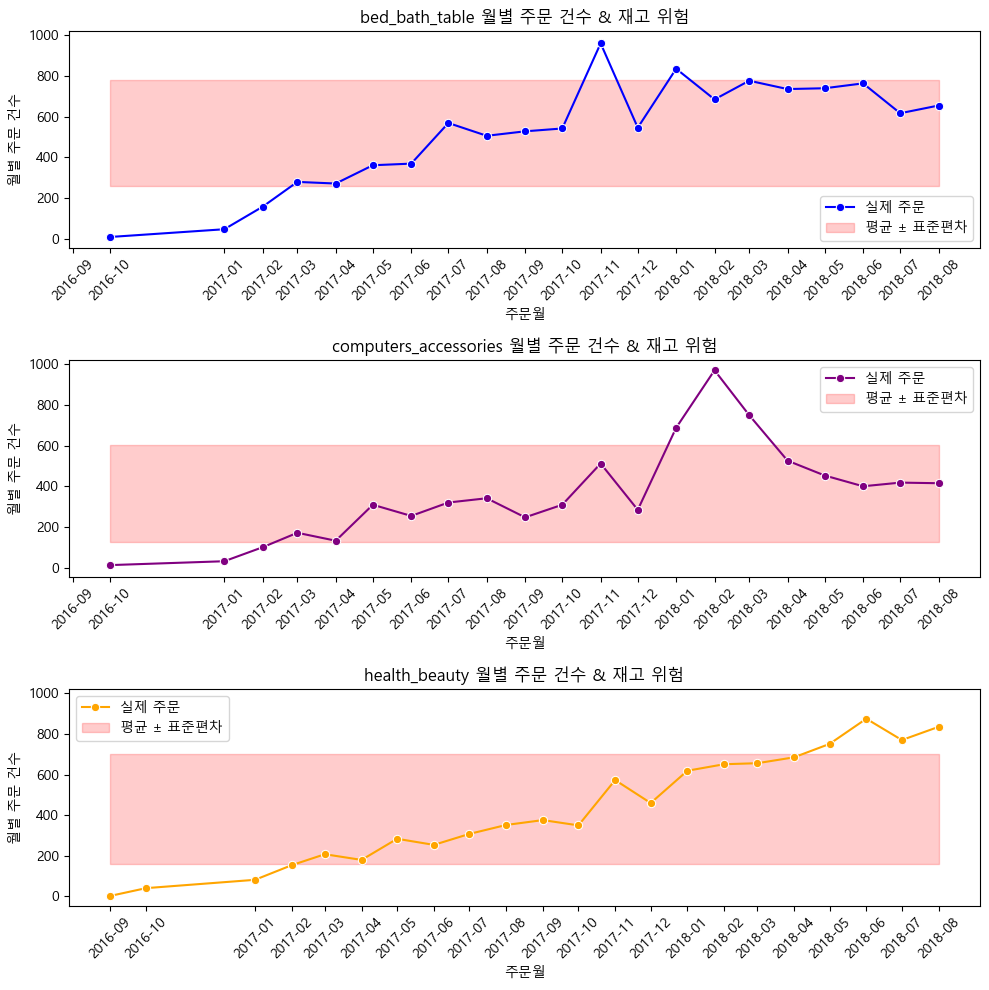

In [9]:
# Î≥¥Í≥† Ïã∂ÏùÄ Ïπ¥ÌÖåÍ≥†Î¶¨ Î¶¨Ïä§Ìä∏
categories = ['bed_bath_table', 'computers_accessories', 'health_beauty']

# subplot ÏÑ§Ï†ï
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharey=True)
axes = axes.flatten()

for i, cat in enumerate(categories):
    df_cat = df[df['product_category']==cat].sort_values('order_month')
    line_colors = {
    'bed_bath_table': 'blue',
    'computers_accessories': 'purple',   # Î≥¥ÎùºÏÉâ
    'health_beauty': 'orange'           # Ï£ºÌô©ÏÉâ
}

    # Ïã§Ï†ú Ï£ºÎ¨∏ Í±¥Ïàò
    sns.lineplot(data=df_cat, x='order_month', y='ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò', marker='o', ax=axes[i], label='Ïã§Ï†ú Ï£ºÎ¨∏',color=line_colors[cat])
    
    # ÌèâÍ∑† ¬± ÌëúÏ§ÄÌé∏Ï∞® Íµ¨Í∞Ñ
    axes[i].fill_between(df_cat['order_month'],
                         df_cat['mean']+df_cat['std'],
                         df_cat['mean']-df_cat['std'],
                         color='red', alpha=0.2, label='ÌèâÍ∑† ¬± ÌëúÏ§ÄÌé∏Ï∞®')
    
    axes[i].set_title(f'{cat} ÏõîÎ≥Ñ Ï£ºÎ¨∏ Í±¥Ïàò & Ïû¨Í≥† ÏúÑÌóò')
    axes[i].set_xlabel('Ï£ºÎ¨∏Ïõî')
    axes[i].set_ylabel('ÏõîÎ≥Ñ Ï£ºÎ¨∏ Í±¥Ïàò')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()
    
    for ax in axes:
        ax.set_xticks(df_cat['order_month'])  # Î™®Îì† Ïõî ÌëúÏãú
        ax.set_xticklabels(df_cat['order_month'].dt.strftime('%Y-%m'), rotation=45)

plt.tight_layout()

plt.show()

In [10]:
print('''
 1Ô∏è‚É£ bed_bath_table

11Ïõî Í∏âÏ¶ù: ÌååÎûÄÏÑ†Ïù¥ ÌÅ¨Í≤å ÌäÄÏñ¥ ÏûàÏùå ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò Îß§Ïö∞ ÎÜíÏùå
Ï†ÑÎûµ: 11Ïõî Ï†ÑÏóê Ïû¨Í≥† Ï∂©Î∂ÑÌûà ÌôïÎ≥¥, ÎÇòÎ®∏ÏßÄ Îã¨ÏùÄ Ïû¨Í≥† Ï°∞Ï†à

      
2Ô∏è‚É£ computers_accessories

12Ïõî~2Ïõî Í∏âÏ¶ù: Î≥¥ÎùºÏÉâ ÏÑ†Ïù¥ Îπ®Í∞Ñ ÏùåÏòÅ ÏúÑÎ°ú ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò
ÌäπÏßï: ÏãúÏ¶åÏÑ± Í∞ïÌï® (ÌïôÍ∏∞ ÏãúÏûë/Ïó∞Îßê ÌñâÏÇ¨ ÏòÅÌñ•)
Ï†ÑÎûµ: ÌïôÍ∏∞ ÏãúÏûë Ï†Ñ, Ïó∞Îßê ÌñâÏÇ¨ Ï†Ñ ÏßëÏ§ë Ïû¨Í≥† ÌôïÎ≥¥


3Ô∏è‚É£ health_beauty

Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÏÉÅÏäπ Ï∂îÏÑ∏: Ï£ºÌô©ÏÉâ ÏÑ†Ïù¥ ÎåÄÎ∂ÄÎ∂Ñ Îπ®Í∞Ñ ÏùåÏòÅ ÏÉÅÎã® Í∑ºÏ≤ò ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò ÏßÄÏÜç
ÌäπÏßï: Í≥ºÏûâ Ïû¨Í≥† Í±∞Ïùò ÏóÜÏùå ‚Üí Íæ∏Ï§ÄÌûà Ïù∏Í∏∞ Ïπ¥ÌÖåÍ≥†Î¶¨
Ï†ÑÎûµ: ÏïàÏ†ïÏ†ÅÏù∏ Í≥µÍ∏â Í¥ÄÎ¶¨, Ïû¨Í≥† Î∂ÄÏ°± ÎåÄÎπÑ ÏßÄÏÜç ÌïÑÏöî

      
üîπ Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏
bed_bath_table ‚Üí 11Ïõî Î∏îÎûôÌîÑÎùºÏù¥Îç∞Ïù¥ ÏãúÏ¶å Ï†Ñ Ïû¨Í≥† ÌôïÎ≥¥, ÎÇòÎ®∏ÏßÄ Îã¨ÏùÄ Í≥ºÏûâ Ïû¨Í≥† Ï£ºÏùò
computers_accessories ‚Üí ÏãúÏ¶åÏÑ± Í∞ïÌïú Ïπ¥ÌÖåÍ≥†Î¶¨, ÌïôÍ∏∞/Ïó∞Îßê Ïù¥Î≤§Ìä∏ Ï†Ñ ÏßëÏ§ë Ïû¨Í≥† ÌôïÎ≥¥
health_beauty ‚Üí Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ïù∏Í∏∞ ÎÜíÏùå, Íæ∏Ï§ÄÌïú Ïû¨Í≥† Ïú†ÏßÄ ÌïÑÏöî '''  )


 1Ô∏è‚É£ bed_bath_table

11Ïõî Í∏âÏ¶ù: ÌååÎûÄÏÑ†Ïù¥ ÌÅ¨Í≤å ÌäÄÏñ¥ ÏûàÏùå ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò Îß§Ïö∞ ÎÜíÏùå
Ï†ÑÎûµ: 11Ïõî Ï†ÑÏóê Ïû¨Í≥† Ï∂©Î∂ÑÌûà ÌôïÎ≥¥, ÎÇòÎ®∏ÏßÄ Îã¨ÏùÄ Ïû¨Í≥† Ï°∞Ï†à


2Ô∏è‚É£ computers_accessories

12Ïõî~2Ïõî Í∏âÏ¶ù: Î≥¥ÎùºÏÉâ ÏÑ†Ïù¥ Îπ®Í∞Ñ ÏùåÏòÅ ÏúÑÎ°ú ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò
ÌäπÏßï: ÏãúÏ¶åÏÑ± Í∞ïÌï® (ÌïôÍ∏∞ ÏãúÏûë/Ïó∞Îßê ÌñâÏÇ¨ ÏòÅÌñ•)
Ï†ÑÎûµ: ÌïôÍ∏∞ ÏãúÏûë Ï†Ñ, Ïó∞Îßê ÌñâÏÇ¨ Ï†Ñ ÏßëÏ§ë Ïû¨Í≥† ÌôïÎ≥¥


3Ô∏è‚É£ health_beauty

Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÏÉÅÏäπ Ï∂îÏÑ∏: Ï£ºÌô©ÏÉâ ÏÑ†Ïù¥ ÎåÄÎ∂ÄÎ∂Ñ Îπ®Í∞Ñ ÏùåÏòÅ ÏÉÅÎã® Í∑ºÏ≤ò ‚Üí Ïû¨Í≥† Î∂ÄÏ°± ÏúÑÌóò ÏßÄÏÜç
ÌäπÏßï: Í≥ºÏûâ Ïû¨Í≥† Í±∞Ïùò ÏóÜÏùå ‚Üí Íæ∏Ï§ÄÌûà Ïù∏Í∏∞ Ïπ¥ÌÖåÍ≥†Î¶¨
Ï†ÑÎûµ: ÏïàÏ†ïÏ†ÅÏù∏ Í≥µÍ∏â Í¥ÄÎ¶¨, Ïû¨Í≥† Î∂ÄÏ°± ÎåÄÎπÑ ÏßÄÏÜç ÌïÑÏöî


üîπ Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏
bed_bath_table ‚Üí 11Ïõî Î∏îÎûôÌîÑÎùºÏù¥Îç∞Ïù¥ ÏãúÏ¶å Ï†Ñ Ïû¨Í≥† ÌôïÎ≥¥, ÎÇòÎ®∏ÏßÄ Îã¨ÏùÄ Í≥ºÏûâ Ïû¨Í≥† Ï£ºÏùò
computers_accessories ‚Üí ÏãúÏ¶åÏÑ± Í∞ïÌïú Ïπ¥ÌÖåÍ≥†Î¶¨, ÌïôÍ∏∞/Ïó∞Îßê Ïù¥Î≤§Ìä∏ Ï†Ñ ÏßëÏ§ë Ïû¨Í≥† ÌôïÎ≥¥
health_beauty ‚Üí Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ïù∏Í∏

In [11]:
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install --upgrade pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install -q prophet

Note: you may need to restart the kernel to use updated packages.


Importing plotly failed. Interactive plots will not work.
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\agnes\pjt-ecommerce-data-analysis\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


           ds          yhat    yhat_lower    yhat_upper
21 2018-08-31  9.223477e+06  9.108267e+06  9.324421e+06
22 2018-09-30  1.679871e+10  1.614618e+10  1.741443e+10
23 2018-10-31  7.813979e+00  7.166972e+00  8.509250e+00
24 2018-11-30 -9.999999e-01 -9.999999e-01 -9.999999e-01
25 2018-12-31  1.025205e+09  8.647575e+08  1.214171e+09
26 2019-01-31  2.868775e+05  2.277444e+05  3.601586e+05
27 2019-02-28  3.176365e+04  2.335199e+04  4.228381e+04
28 2019-03-31  1.178367e+04  8.178813e+03  1.697184e+04
29 2019-04-30  1.494712e+03  9.745291e+02  2.296072e+03
30 2019-05-31  1.043424e+03  6.256729e+02  1.709168e+03
31 2019-06-30  2.881831e+01  1.547861e+01  5.142107e+01
32 2019-07-31  9.262752e+01  4.637275e+01  1.763335e+02


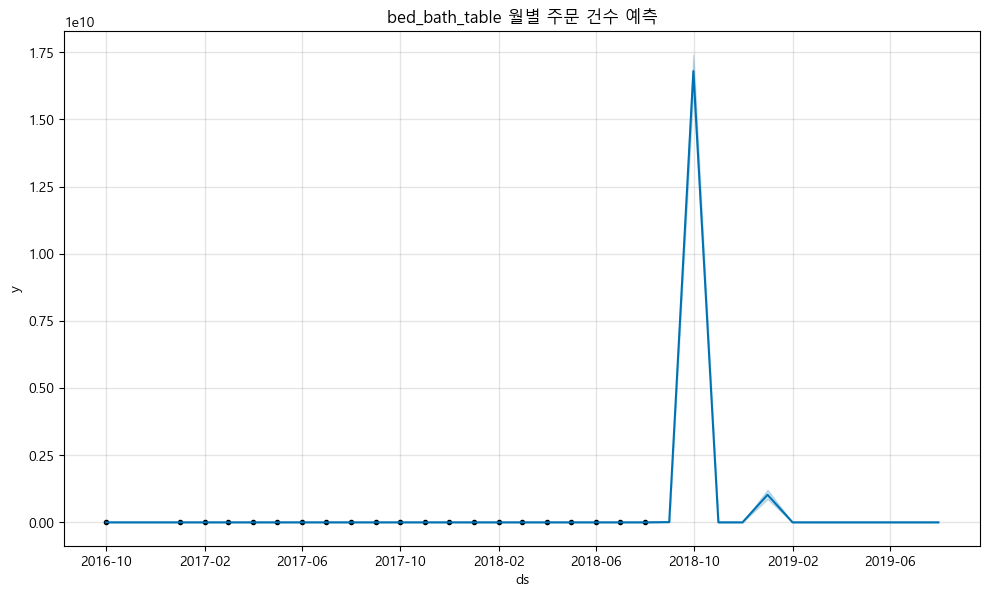

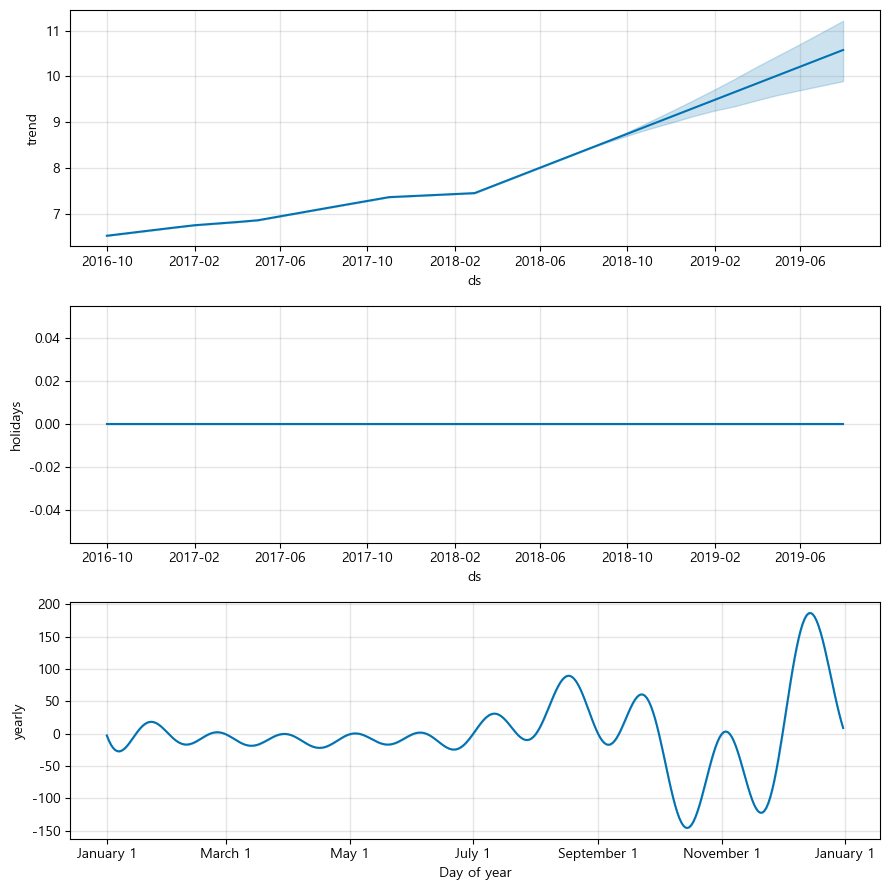

In [14]:
from prophet import Prophet

# ds Ïª¨ÎüºÏúºÎ°ú Î≥ÄÌôò (Prophet ÏöîÍµ¨)
monthly_category_trend['ds'] = pd.to_datetime(monthly_category_trend['order_month']).dt.to_period('M').dt.to_timestamp()
monthly_category_trend['y'] = monthly_category_trend['ÏõîÎ≥ÑÏ£ºÎ¨∏Í±¥Ïàò']

# ÌäπÏ†ï Ïπ¥ÌÖåÍ≥†Î¶¨ ÏÑ†ÌÉù (Ïòà: bed_bath_table)
df_cat = monthly_category_trend[monthly_category_trend['product_category']=='bed_bath_table'][['ds','y']]

# Î°úÍ∑∏ Î≥ÄÌôò (Î≥ÄÎèôÌè≠Ïù¥ ÌÅ∞ Í≤ΩÏö∞ ÏïàÏ†ïÌôî)
df_cat['y'] = np.log1p(df_cat['y'])

events = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(['2016-11-25', '2018-11-24']),  # 2ÎÖÑÏπò Îç∞Ïù¥ÌÑ∞ Í∏∞Ï§Ä
    'lower_window': 0,
    'upper_window': 1
})


model = Prophet(yearly_seasonality=True, holidays=events)
model.fit(df_cat)

# ÎØ∏Îûò 12Í∞úÏõî ÏòàÏ∏°
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# ÏòàÏ∏°Í∞í ÏõêÎûò Ïä§ÏºÄÏùºÎ°ú Î≥ÄÌôò
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])


# ÏµúÍ∑º ÏòàÏ∏°Í∞í ÌôïÏù∏
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12))

# Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî
fig1 = model.plot(forecast)
plt.title('bed_bath_table ÏõîÎ≥Ñ Ï£ºÎ¨∏ Í±¥Ïàò ÏòàÏ∏°')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()